In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dfs = []
files = glob.glob("/scratch/users/schuetzn/data/mhc_dataset/*/metadata.parquet")
for file in files:
    hq = file.split("/")[-2]
    df = pd.read_parquet(file)
    df["healthCode"] = hq
    dfs.append(df)


In [3]:
df = pd.concat(dfs)

In [4]:
stats = df.groupby("healthCode")["date"].apply(lambda x: len(np.unique(x)))

/tmp/ipykernel_6906/3863284072.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[str(t) for t in thresholds], y=counts, palette="viridis")


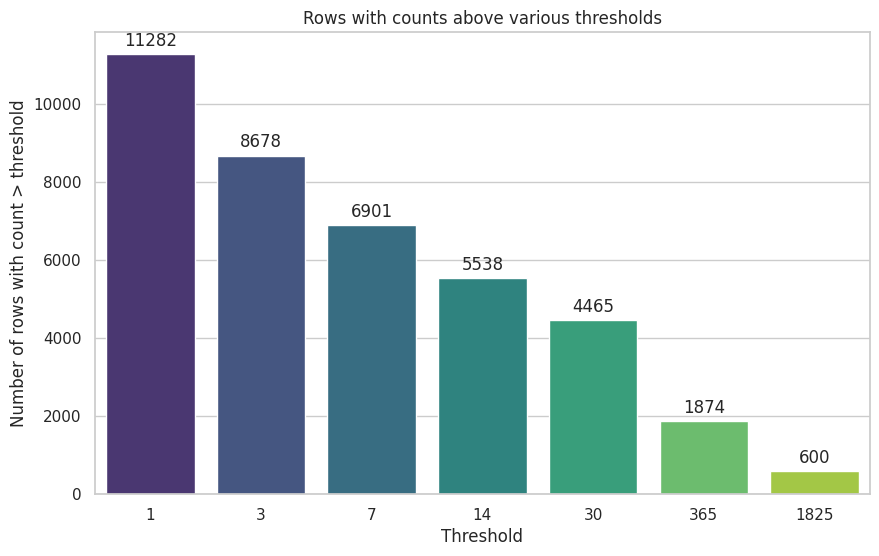

In [12]:
counts_series = coverage_df.groupby("healthCode").data_coverage_sum.count()
thresholds = [1, 3, 7, 14, 30, 365, 5 * 365]
values = [(counts_series > t).sum() for t in thresholds]
counts = [(counts_series > t).sum() for t in thresholds]


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=[str(t) for t in thresholds], y=counts, palette="viridis")
for i, count in enumerate(counts):
    ax.text(i, count + max(counts) * 0.01, str(count), ha='center', va='bottom', fontsize=12)
plt.xlabel("Threshold")
plt.ylabel("Number of rows with count > threshold")
plt.title("Rows with counts above various thresholds")
plt.show()

In [6]:
daily_stats = []
for idx, row in df.groupby(["healthCode", "date"]):
    data_coverage_sum = row.data_coverage.sum()
    data_coverage_mean = row.data_coverage.mean()
    n_above_zero = row[row.data_coverage > 0]
    daily_stats.append({
        "data_coverage_sum": data_coverage_sum,
        "data_coverage_mean": data_coverage_mean,
        "n_above_zero": len(n_above_zero),
        "healthCode": row["healthCode"].iloc[0]
    })

In [7]:
data_coverage_mean

0.7783564814814815

In [9]:
len(daily_stats)

4246004

In [1]:
import pickle
#with open("../summary_daily.pkl", "wb") as f:
#    pickle.dump(daily_stats, f)
with open("../summary_daily.pkl", "rb") as f:
    daily_stats = pickle.load(f)

In [11]:
coverage_df.groupby("healthCode").data_coverage_sum.count()

healthCode
-72lErpUJHq6Yom2XiuN57mJ    3103
-7tzqFrFEohYxCtg9zEfVPk5    1573
-ILHQwUPTRpgCMsco78lptlp    1140
-RIrBo4FlUhk9xpHMZcqgWFS     514
-TwtBb5CZaoJZ4_sLVUj5843    1933
                            ... 
zVKmAvuLW5hGQejGGwQpDbLR      74
z_J-eptU7dOXMVf6Twu3Jif8     527
zs0WkHsozgdR1V-izdp5tH2O    1609
zta1mG5URz9sGb0we1BIejda    2468
zuMPDcR2UrKM3fsmqfliei_r    2733
Name: data_coverage_sum, Length: 12439, dtype: int64

In [3]:
info_df = pd.read_parquet('../myheart-counts-client/mhc_full_participant_info.parquet')

In [4]:
healthCodes_open_sharing = set(info_df[info_df.sharingScope == "all_qualified_researchers"].healthCode)

In [5]:
healthCodes_open_sharing

{'cdb917b7-d3d2-433e-ac1c-6906f11edd61',
 'fcc5f177-31ab-4dee-af0c-58be431d4c38',
 '0ad6f77e-c588-4a90-b38f-ca403755f213',
 '2cafbc58-dd79-4dd3-9735-c0d160c817c8',
 'a65f098b-95b0-4e41-a15c-3b9bd59b8b15',
 '4380e5d4-11b3-405f-99e2-22859736f54d',
 '93b98a80-c2e8-469a-876c-9ea3bff37a7e',
 '494893a5-0414-48c9-a082-cfc6a072a810',
 '86a247fb-274b-476e-af4b-8d653db8b38a',
 '4911d6dd-907c-4675-a7e5-f597fbd197bf',
 'ea558da8-033c-4091-a4a4-77fda8eea430',
 '9a27c6d5-8d77-4d43-9974-4ebd0588e4ff',
 'c2c0a110-51ed-43fb-89f0-c3a452b9e6c8',
 '16b966b5-de5a-4bc2-b64e-145685a4a5c2',
 '4200a63a-6981-41e7-966e-1c1e23b8e4bb',
 '0fd7dcd1-2844-4f61-99f5-0bc08ea59d47',
 'b79aefb1-3c38-46a8-ba7b-b29a12a01c51',
 '08043499-4ce7-43a0-9dff-1c44450fac32',
 'e32cf287-dacc-43cf-9663-ce3ae2a9b36b',
 '886a1bcc-6176-47eb-a722-403c3307f809',
 'e956c442-831f-4c65-973e-e510a8b4f18f',
 '9be42a6f-2952-46ce-ab17-05d31223462f',
 '82e5d2fb-ccdd-4210-9d91-7cb293e13602',
 '2b8f5541-9be1-4e32-85c2-bd8b7c331c1e',
 'da78ef03-da2d-

In [6]:
coverage_df = pd.DataFrame(daily_stats)
len(coverage_df)

4246004

In [7]:
coverage_df = coverage_df[coverage_df.healthCode.isin(healthCodes_open_sharing)]

## Days with ANY data

In [8]:
len(coverage_df[coverage_df.data_coverage_sum > 0])

2605461

/tmp/ipykernel_6906/3850892407.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[str(t) for t in thresholds], y=counts, palette="viridis")


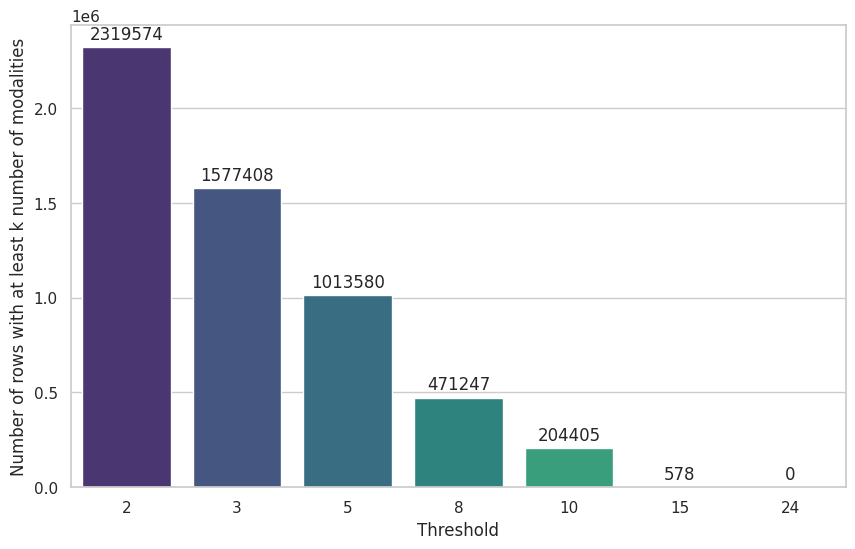

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

thresholds = [2, 3, 5, 8, 10, 15, 24]
counts = [len(coverage_df[coverage_df.n_above_zero >= t]) for t in thresholds]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=[str(t) for t in thresholds], y=counts, palette="viridis")
for i, count in enumerate(counts):
    ax.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom', fontsize=12)
plt.xlabel("Threshold")
plt.ylabel("Number of rows with at least k number of modalities")
#plt.title("Rows with n_above_zero above various thresholds")
plt.show()

/tmp/ipykernel_7611/3573528286.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[str(t) for t in thresholds], y=unique_counts, palette="viridis")


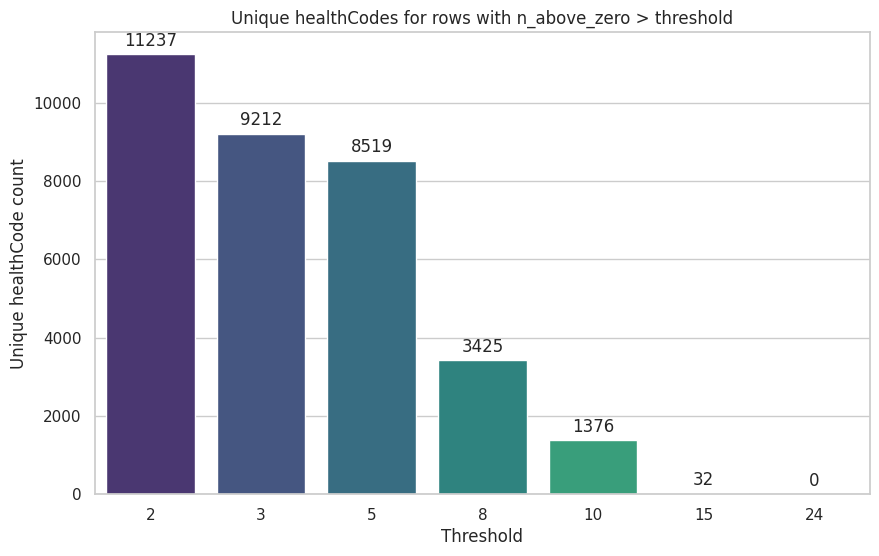

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = [2, 3, 5, 8, 10, 15, 24]
unique_counts = [coverage_df[coverage_df.n_above_zero > t]['healthCode'].nunique() for t in thresholds]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=[str(t) for t in thresholds], y=unique_counts, palette="viridis")
for i, count in enumerate(unique_counts):
    ax.text(i, count + max(unique_counts)*0.01, str(count), ha='center', va='bottom', fontsize=12)
plt.xlabel("Threshold")
plt.ylabel("Unique healthCode count")
plt.title("Unique healthCodes for rows with n_above_zero > threshold")
plt.show()